# Uncertainty quantification for outcome modelling in radiation oncology: an illustrative example

## Introduction

Outcome modelling is an important tool in radiation oncology to guide treatment decisions. 
Applying these models into clinical practice requires reliable model outputs. 
In this context, uncertainty quantification can be used to assess reliability, interpretability and explainability for various modelling strategies. 
However, the quantification of uncertainties of outcome models in radiation oncology is still rarely done. <br>
Aiming to inspire researchers to build upon current knowledge about uncertainty quantification, we summarised basic concepts in a topical review: ```We will provide further information soon.``` <br>
In this notebook, we provide an example for the application of the presented methods for uncertainty quantification. 

### Aim
This notebook aims to demonstrate basic concepts of how different methods for uncertainty quantification can be used for or integrated in outcome modelling in radiation oncology.
Here, we use an artificial example of predicting radiation induced pneumonitis after irradiation.
We aim to provide examples for the implementation of modelling approaches as well as the respective presentation and analysis of the results. 
We hope, this notebook will simplify the entry into uncertainty modelling for researchers and inspires the radiation oncology community to comprehensively include uncertainty quantification techniques in outcome modelling.

### Outline
The notebook is structured as follows:
<ol>
    <li>Data preparation</li>
    <li>Model development</li> 
    <li>Methods for uncertainty quantification</li> 
        <ol>
            <li>Ensemble methods</li>
            <li>Bayesian methods</li>
            <li>Test-time augmentation (TTA) methods</li>
        </ol>
    <li>Application of uncertainty quantification</li>
        <ol>
            <li>In-distribution dataset</li>
            <li>Shifted dataset</li>
            <li>Out-of-distribution dataset</li>
        </ol>
    <li>Evaluation of uncertainty quantification</li>
    <ol>
        <li>Sparsification plots</li>
        <li>Conformal prediction</li>
    </ol>
    <li>Summary</li>
</ol>


### Dataset
For our demonstration example, we used an R-script to artificially create a dataset based on the cohort used by ```Yakar M et al. Technology in Cancer Research & Treatment. 2021;20. doi:10.1177/15330338211016373```. <br>
Our dataset consists of 200 patients and comprises three features:
- Dose in Gy that is applied to 5% of the lunge volume ($D5\%$): dose_to_5_percent_of_lung_volume
- Gross tumour volume (GTV) in $cm^3$: gross_tumour_volume
- Number of cycles of chemotherapy as integer: n_chemotherapy_cycles

The studied outcome variable is the presence of a radiation induced pneumonitis:
- outcome $\in$ {0, 1}: 0 - no radiopneumonitis; 1 - radiopneumonitis

In general, the following correlations apply:
- The risk of radiopneumonitis increases with the dose to 5% of the lung volume.
- The risk of radiopneumonitis increases with the gross tumour volume.
- The risk of radiopneumonitis increases with the number of applied chemotherapy cycles. 

A more detailed description can be found in the R-file used for creation. <br>
Note: Although all features represent physical quantities with respective units, we use and report <b>dimensionless values</b> for reasons of simplicity in the entire script.

### Variables
- $p$ - predicted probability for an outcome
- $s$ - standard deviation
- $d$ - distance
- $\beta$ - model parameter
- $X$ - observed features
- $x$ - feature realisation
- $y$ - observed outcomes
- $N$ - number of samples
- $p$ - p-value
- $\alpha$ - non-conformity measure / score
- $\varepsilon$ - significance level
 
### Abbreviations
- AUC - Area Under the Curve
- FPR / TPR - False Positive Rate / True Positive Rate
- ROC - Receiver Operating Curve

### Dependencies
The demonstration example was developed using Python (Version 3.11.6) and requires working versions of NumPy, SciPy, pandas, matplotlib, seaborn, scikit-learn, statsmodels, PyMC and ArviZ.

### Citation info
If you use this file, please cite the following paper: <br>
```We will provide further information soon.```



### Import of the required packages

In [1]:
# Standard packages for data processing - we use NumPy (Version 1.26.0) and pandas (Version 2.1.3)
import numpy as np
import pandas as pd

# Packages for plotting
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

# For model development and assessment of model performance we use scikit-learn (Version 1.4.0)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
# The resample function from sklearn is used for bootstrapping, e.g. for the ensemble method
from sklearn.utils import resample
# Prinicipal component analysis is used for comparison of datasets
from sklearn.decomposition import PCA  

# For statistical computations and the respective presentation of the results we use statsmodels (Version 0.14.1)
import statsmodels.api as sm

# For the implementation of an Bayesian method we use PyMC (Version 5.20.1) and ArviZ (Version 0.20.0)
import pymc as pm
import arviz as az

# We use scipy (Version 1.11.3) for calculation of k-nearest neighbours for the deterministic method
from scipy.spatial import KDTree

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


### Definition of functions to assess and plot relevant statistical values

In [2]:
def calc_metrics(predictions, y_test):
    """
    Prints the accurarcy and F1-score for the predictions in reference to the observed (true) outcomes.
    
    Args:
      predictions (1d array-like): Predictions of the model - one-dimensional array with the length of the analysed samples
      y_test (1d array-like): Observed values - one-dimensional array with the length of the analysed samples

    Returns:
      None

    """
    accuracy = accuracy_score(y_test, predictions)
    f1_metric = f1_score(y_test, predictions)

    print('Accuracy of the model: {:.2f}%'.format(100*accuracy))
    print('F1 Score of the model: {:.4f}'.format(f1_metric))

    return None  

## 1. Data preparation

The data is read from a .csv-file and stored in a pandas DataFrame. To briefly analyse the structure of the dataset, the first rows are shown:

In [3]:
data = pd.read_csv(r'synthetic_data/synthetic_data.csv', sep=';')
data.head()

,dose_to_5_percent_of_lung_volume,gross_tumour_volume,n_chemotherapy_cycles,radiopneumonitis
0,36,71,0,0
1,8,10,0,0
2,32,138,2,0
3,12,11,0,0
4,47,10,0,1


For further processing, we store the realisation of the feature values in a pandas DataFrame. Furthermore, the observed outcome variables are saved in a separate one-dimensional DataFrame:

In [4]:
features = data.drop(columns='radiopneumonitis')
outcome = data.radiopneumonitis

<b> Preprocessing </b> <br>
Next, the dataset needs to be preprocessed for analysis. <br>

Data preprocessing is problem-specific and can involve various methods. The demonstration dataset has no missing values, and datatypes and units are correct and consistent.

In this minimal example, our preprocessing pipeline comprises the following steps:
<ol>
    <li> The gross tumor volume is logarithmised due its distribution being strongly left-skewed. Cave: in the following, the feature name "gross tumor volume" addresses the logarithmic of the observed features
    <li> Features are normalised to zero mean and unit variance using z-score normalisation to ensure that features are within the same order of magnitude. Note: the mean and standard deviation will be reused later for application to new datasets.</li>
</ol>

In [5]:
features_log = features.copy()
features_log.gross_tumour_volume = np.log(features_log.gross_tumour_volume) 

mean = features_log.mean() 
std = features_log.std()
features_norm = (features_log - mean) / std

For model development and subsequent validation, the dataset is split into a <b> training and a test subset </b> in the ratio of 75\% : 25\%. <br>
Below we apply the following nomenclature:
- $X$: Data points in the training set - pandas DataFrame with $N_{\mathrm{train}}$ x 3 parameters
- $y$: Observed outcomes of the samples in the training set - pandas Series with $N_{\mathrm{train}}$ elements
- $X_{\mathrm{test}}$: Data points in the test set - pandas DataFrame with $N_{\mathrm{test}}$ x 3 parameters
- $y_{\mathrm{test}}$: Observed outcomes of the samples in the test set - pandas Series with $N_{\mathrm{test}}$ elements

with 
- $N_{\mathrm{train}}$: number of patients in the training subcohort
- $N_{\mathrm{test}}$: number of patients in the testing subcohort


In [6]:
X, X_test, y, y_test = train_test_split(features_norm, outcome, test_size=0.25, random_state=50)

## 2. Model development

In the following we apply <b> logistic regression </b> to model the correlation $f$ between the probability of radiation induced pneumonitis (outcome $∈ [0, 1]$) with the extracted features. <br>
Logistic regression converts the linear combination of our features (the $logit$) into an outcome-related probability $ 0 \leq p \leq 1$:
$$
 p = \frac{1}{1 + e^{-logit}}
$$ <br>
with the $logit$:
$$
logit = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \beta_{3}x_{3}
$$ <br>

$\beta_{i}$ - model parameter <br> 
$x_{i}$ - value of each of the three features <br> 


During modelling, the parameters of the logistic regression $\beta_{i}$ are optimised using the data from the training cohort, i.e. the observed features $X$ and the observed outcomes $y$. <br>

We apply the following definition:

- $\beta_{0}$ - constant model parameter 
- $\beta_{1}$ - model parameter for $x_{1}$ = $X$(dose_to_5_percent_of_lung_volume)
- $\beta_{2}$ - model parameter for $x_{2}$ = $X$(gross_tumour_volume)
- $\beta_{3}$ - model parameter for $x_{3}$ = $X$(n_chemotherapy_cycles)

For the logistic regression, we use scikit-learn:

In [7]:
lr = LogisticRegression(penalty=None)
lr.fit(X, y)

# Assess the model parameters
print('Model coefficients: \n',
      'beta0 - constant : ', '{:.3f}'.format(lr.intercept_[0]), '\n',
      'beta1 - ', features.columns[0],': ','{:.3f}'.format(lr.coef_[0][0]), '\n',
      'beta2 - ', features.columns[1],': ','{:.3f}'.format(lr.coef_[0][1]), '\n',
      'beta3 - ', features.columns[2],': ','{:.3f}'.format(lr.coef_[0][2]), '\n'
      )

Model coefficients: 
 beta0 - constant :  -1.540 
 beta1 -  dose_to_5_percent_of_lung_volume :  1.277 
 beta2 -  gross_tumour_volume :  0.544 
 beta3 -  n_chemotherapy_cycles :  0.915 



The fitted model can now be applied to the training data $X$ to assess the training performance.
Applying the model to data from the test cohort $X_{\mathrm{test}}$ allows for an internal validation as the model has not seen these datapoints during training / modelling.

Using our model - we can predict an outcome as well as the correpsonding probability:

In [8]:
# Outcome prediction for the training cohort
lr_train = lr.predict(X)
lr_train_proba = lr.predict_proba(X)[:,1]

# Outcome prediction for the test cohort
lr_test = lr.predict(X_test)
lr_test_proba = lr.predict_proba(X_test)[:,1]

To analyse the performance of the model, we assess the accuracy and the F1-score:

In [9]:
print('TRAINING - Performance')
print('-----------------------')
calc_metrics(lr_train, y)

print('')
print('TEST Performance')
print('-----------------------')
calc_metrics(lr_test, y_test)

TRAINING - Performance
-----------------------
Accuracy of the model: 86.00%
F1 Score of the model: 0.7961

TEST Performance
-----------------------
Accuracy of the model: 72.00%
F1 Score of the model: 0.6316


Furthermore, the ROC and the correpsonding AUC score can be visualised to assess model performance:

(0.0, 1.0)

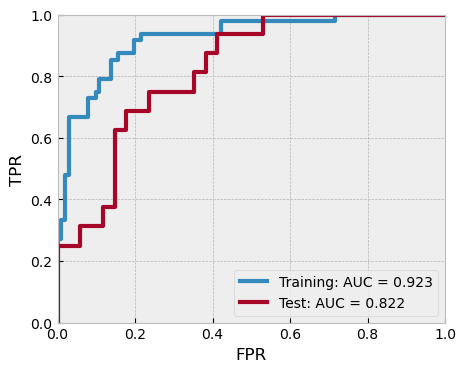

In [10]:
# TRAINING - Performance
auc_train = roc_auc_score(y, lr_train_proba)              # Calculate the AUC-score
fpr_train, tpr_train, _ = roc_curve(y, lr_train_proba)    # Calculate the false positive rate (fpr) and the true positive rate (tpr) - needed for the visual representation of the ROC 

# TEST - Performance
auc_test = roc_auc_score(y_test, lr_test_proba)             # Calculate the AUC-score
fpr_test, tpr_test, _ = roc_curve(y_test, lr_test_proba)    # Calculate the false positive rate (fpr) and the true positive rate (tpr) - needed for the visual representation of the ROC 

# Plot the ROC curve with the integrated representation of the AUC-score
fig = plt.figure(figsize=(5, 4))
plt.plot(fpr_train, tpr_train, linewidth=3, label='Training: AUC = %0.3f' % auc_train)
plt.plot(fpr_test, tpr_test, linewidth=3, label='Test: AUC = %0.3f' % auc_test)
plt.legend(loc='lower right')
plt.xlabel('FPR', size=12)
plt.ylabel('TPR', size=12)
plt.xlim([0, 1])
plt.ylim([0, 1])

Analysing the metrics as well as the ROC and the AUC shows that the model performs well on the training and internal test set.

## 3. Methods for uncertainty quantification
Now let's look at how to quantify the uncertainty of the model. <br>
For logistic regression, the uncertainty can be derived from the variance-covariance matrix. <br> 
Unfortunately, scikit-learn does not offer the possibility to access them or to display additional statistics. 
For this reason, we fit the model again using the statsmodels library. 
Since we did not specify an optimisation setting in our first attempt, the result should be comparable to that of scikit-learn. <br>
Here we can display a summary showing the <b> standard error and p-values for all coefficients </b>, which provide a statement about the significance. <br>
The standard error provides a measure of the spread of the parameters and is thus an estimate of how uncertain the estimate of the parameter is.

In [11]:
logit_model = sm.Logit(y, sm.add_constant(X))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.329973
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       radiopneumonitis   No. Observations:                  150
Model:                          Logit   Df Residuals:                      146
Method:                           MLE   Df Model:                            3
Date:                Thu, 27 Feb 2025   Pseudo R-squ.:                  0.4736
Time:                        10:13:59   Log-Likelihood:                -49.496
converged:                       True   LL-Null:                       -94.030
Covariance Type:            nonrobust   LLR p-value:                 3.471e-19
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -1.5390      0.354     -4.34

### 3.1. Ensemble methods
An ensemble comprises different models. 
Applying the ensemble to a data point leads to as many different results as there are models in the ensemble. These distinct results can then be used for uncertainty quantification.
Multiple different models can be trained using bootstrapping. Because in each bootstrap the underlying data is different, models are optimised differently.

For our example, we infer $N = 10000$ bootstrapped sets and use them for training an ensemble of $N = 10000$ models. 
For each model, we store the fitted model parameters, i.e. the three modelling parameters for the three features ($\beta_1$, $\beta_2$, $\beta_3$) as well as the constant value $\beta_0$ in a pandas DataFrame: params_ens. <br>

Note: In our example, each logistic regression model can be characterised by only 4 parameters. Other, more complex models, need to be retained in full for inference.


In [12]:
param_ens = pd.DataFrame(columns= ['constant'] + X.columns.tolist())      # Save the parameters of each trained model

n = 10000
for i in range(n):
    X_ens, y_ens = resample(X, y, replace=True, random_state=i)
    lr_ens = LogisticRegression(penalty=None)
    lr_ens.fit(X_ens, y_ens)
    param_ens.loc[i] = [lr_ens.intercept_[0]] + list(lr_ens.coef_[0])

For each model parameter, our ensemble contains as many different realisations, as models were trained.
We can analyse the results by plotting histograms of the estimated model parameters and calculating the mean and standard deviation:

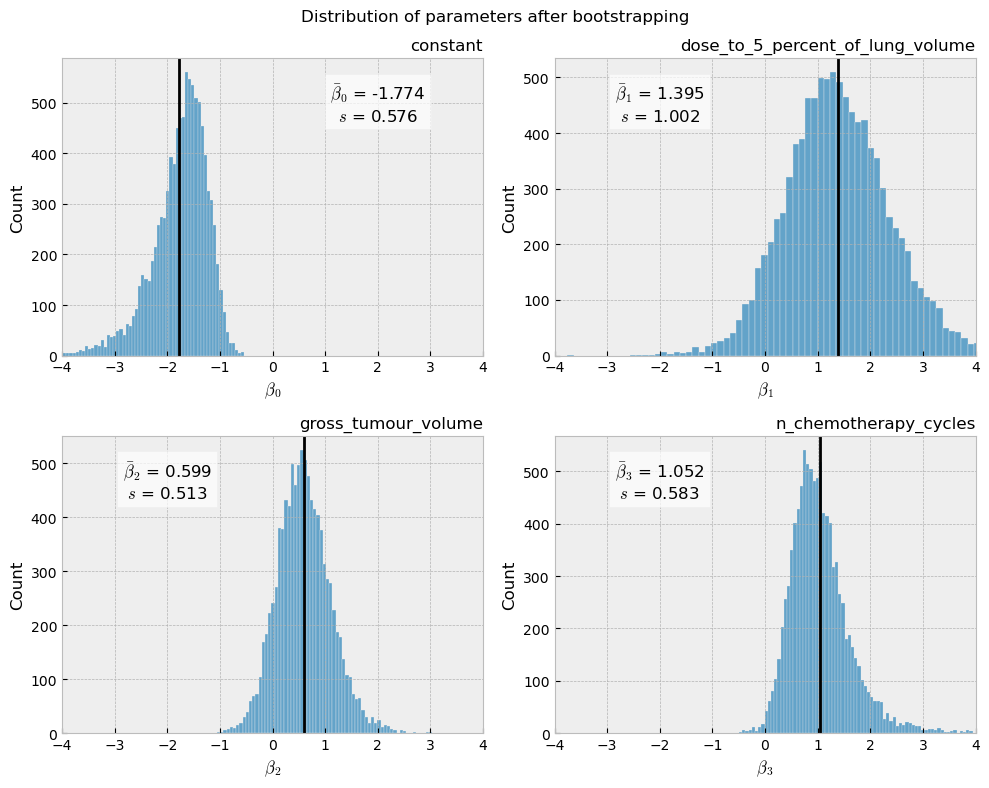

In [13]:
n_rows = int(np.ceil(param_ens.shape[1]/2))
fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows*4))
fig.suptitle('Distribution of parameters after bootstrapping', fontsize=12)

x_lim = np.ceil(max((np.abs(min(param_ens.quantile(0.05))), abs(max(param_ens.quantile(0.95))))))     # Define limits of the x-axis based on the 5th and 95th percentile of the coefficients. The global minimum and maximum are chosen to ensure comparable axis-limitations

for c in param_ens:
      i = param_ens.columns.get_loc(c)
      ax = axes.flat[i]
      sns.histplot(param_ens[c], ax=ax, fill=True)
      ax.axvline(np.mean(param_ens[c]), color='k', lw=2)      
      ax.set_xlim(-x_lim, x_lim)
      _, max_ylim = ax.get_ylim()
      
      if np.mean(param_ens[c]) < 0:
            pos_ann_x = x_lim/2
      else:
            pos_ann_x = -x_lim/2    

      ax.text(pos_ann_x, max_ylim*0.85,  r"$\bar \beta$" + r"$_{:.0f}$".format(i) + ' = {:.3f}'.format(param_ens[c].mean()) + '\n' + r'$s$ = {:.3f}'.format(param_ens[c].std()), 
              fontsize=12, color="black", ha="center", va="center", 
              bbox=dict(facecolor='white', alpha=0.7))
      
      ax.set_title(c, loc='right', fontsize=12)
      ax.set_xlabel(r"$\beta$" + r"$_{:.0f}$".format(i), fontsize=12)

plt.tight_layout()
plt.show()

The histograms show that for all parameters a (partially skewed) normal distribution can be approximated. <br>
Furthermore, we see that the resulting means of the modelling parameters are of the same order of magnitude as determined by the logistic regression model.

<b> Application of the ensemble: </b> 
During inference, all model combinations are applied to every datapoint. 
A measure of spread such as the standard deviation $s$ can then be used to quantify the uncertainty for this datapoint. <br>

In [14]:
def ensemble_inferred_uncertainty(param, data):
    """
    Infering the ensemble comprising logistic regression models on a sample with specific realisation of features (x1, x2, x3). 
    The regression parameters (beta0, beta1, beta2, beta3) are stored in a pandas DataFrame which is passed as input parameter.
    For each model of the ensemble, the outcome is calculated using:
    p = 1 / (1 + exp(-(beta0 + beta1*x1 + beta2*x2 + beta3*x3)))
    
    Args:
      param (pandas DataFrame): Parameters of the models forming the ensemble - Two-dimensional DataFrame whereas each row comprises the parameters for one model and the parameters are stored columnwise (beta0, beta1, beta2, beta3)
      data (pandas DataFrame): Data point - One-dimensional DataFrame containing the observed features (x1, x2, x3)

    Returns:
      p (pandas Series): Predicted probabilities for the outcome - 1 value for each model of the ensemble
    """
    
    logit = param.iloc[:, 0] + param.iloc[:, 1]*data.iloc[0] + param.iloc[:, 2]*data.iloc[1] + param.iloc[:, 3]*data.iloc[2]
    p = 1 / (1 + np.exp(-logit))
    return p

### 3.2. Bayesian methods

Bayesian models learn distributions instead of point estimates. Following the Bayesian theorem, a posterior distribution is inferred from a prior and a likelihood distribution. Generally, the calculation of this posterior distribution is intractable. Therefore, methods were developed to approximate the posterior. <br> 
In the following example we use a <b>Markov Chain Monte Carlo (MCMC)</b> method to sample from a distribution that resembles the posterior using the PyMC library. <br>
The setup of the model requires the following information:
- Priors for the model parameters: We assume a normal distribution $\mathcal{N} (\mu,0.5)$ for all parameters as a starting point with $\mu$ based on the model parameters of our logistic model.
- A function to calculate the probability for a given input: This is the equation for the logistic regression.
- A likelihood function for our observed data: We assume a Bernoulli distribution as this is a binary classification problem. 



Samples are now drawn from the posterior in four chains until $N = 3000$ samples are drawn in each chain (after a tuning phase of $N = 2000$ samples).

In [15]:
with pm.Model() as logistic_model:
    # Priors for coefficients, values for initialization are adjusted based on the results of the ensemble
    beta0 = pm.Normal("beta0", mu=-1.5, sigma=0.5)
    beta1 = pm.Normal("beta1", mu=1.3, sigma=0.5)
    beta2 = pm.Normal("beta2", mu=0.5, sigma=0.5)
    beta3 = pm.Normal("beta3", mu=0.9, sigma=0.5)
    
    # Logistic regression equation
    logits = beta0 + beta1*X.iloc[:,0] + beta2*X.iloc[:,1] + beta3*X.iloc[:,2]
    p = pm.Deterministic("p", pm.math.sigmoid(logits)) 
    
    # Likelihood (observed data)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)
    
    # Sample from the posterior
    rng = np.random.default_rng(42)
    idata = pm.sample(3000, tune=2000, target_accept=0.9, chains=4, return_inferencedata=True, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 808 seconds.


To analyse the results, we plot the posterior (left column) and the values of the $N = 3000$ drawn samples (right column) using the the arviz-library. The results for the chains are displayed using different linestyles:

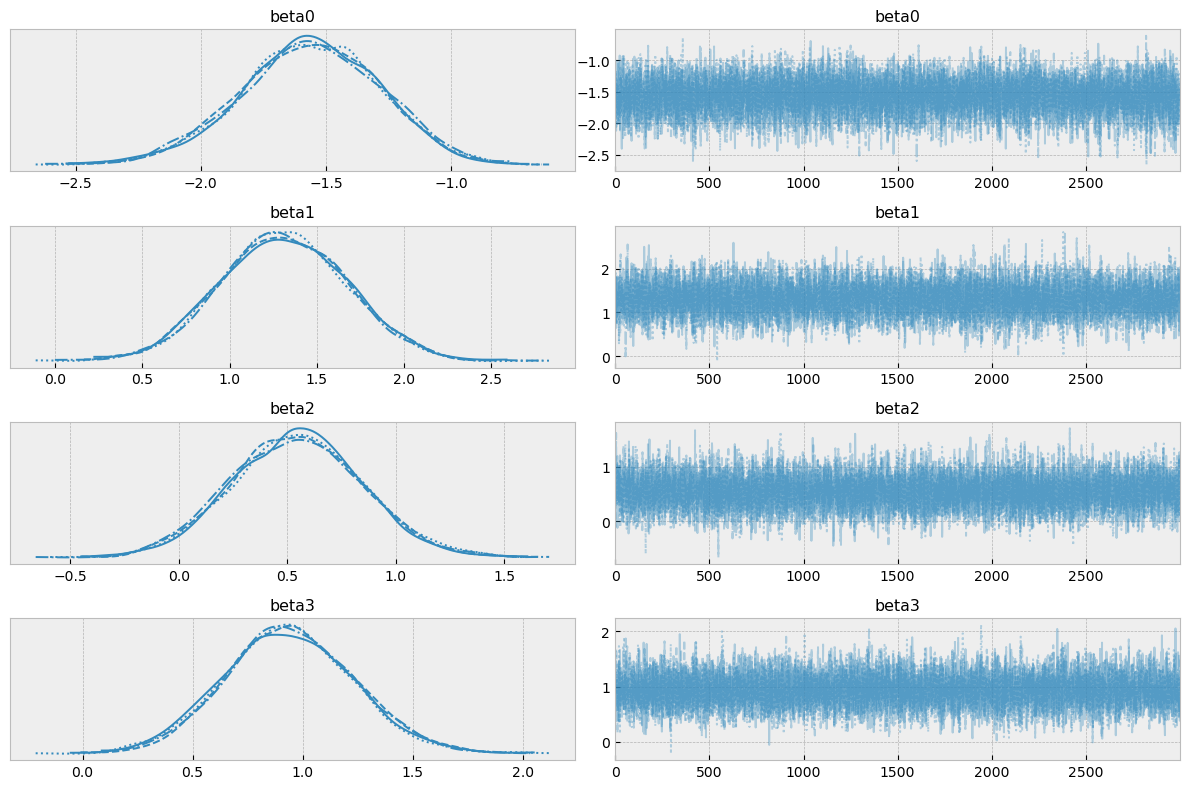

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-1.565,0.278,-2.090,-1.049,0.003,0.002,10760.0,8678.0,1.0
beta1,1.311,0.365,0.631,1.992,0.004,0.003,9115.0,8236.0,1.0
beta2,0.546,0.301,-0.024,1.107,0.003,0.002,10754.0,8201.0,1.0
beta3,0.939,0.293,0.397,1.496,0.003,0.002,8869.0,7206.0,1.0


In [16]:
az.plot_trace(idata, var_names=["beta0", "beta1", "beta2", "beta3"])
plt.tight_layout()
plt.show()

az.summary(idata, var_names=["beta0", "beta1", "beta2", "beta3"])

The visualisation of the results shows for each parameter that all chains resulted in similar distributions, implicating that a stable solution was found.

Inference of uncertainty is performed in a similar way as for the ensemble method. The posterior-object includes the drawn samples of the parameters for all  chains. Since all  chains gave similar results, we only use one.

In [17]:
def bayesian_inferred_uncertainty(post, data):
    """
    Infering the Bayesian logistic regression model on a sample with specific realisation of features (x1, x2, x3). 
    The regression parameters (beta0, beta1, beta2, beta3) are stored in the inferred posterior object which is passed as input parameter. Here, the results of the first chain are used.
    p = 1 / (1+ exp(-(beta0 + beta1*x1 + beta2*x2 + beta3*x3)))
    
    Args:
      post (posterior from the InferenceData object): Parameters of the models drawn from the posterior
      data (pandas DataFrame): Data point - One-dimensional array containing the features (x1, x2, x3)
    
    Returns:
      p (pandas Series): Predicted probabilities for the outcome
    """

    logit = post['beta0'][0] + post['beta1'][0]*data.iloc[0] + post['beta2'][0]*data.iloc[1] + post['beta3'][0]*data.iloc[2]
    p = 1 / (1 + np.exp(-logit))
    return pd.Series(p)

### 3.3. Test-time augmentation (TTA) methods
TTA-methods alter the existing data to synthesise new realistic samples. These can be used to infer aleatoric uncertainties based on the change in the results. For example, image data can be rotated or additional noise can be added. For tabular data, realistic values for variations can be taken from the literature or experiments. <br>
In our example, we augment the features “dose_to_5_percent_of_lung_volume” and “gross_tumour_volume” as these two features could change due to different contouring. For this reason, we multiply both by a factor drawn from a normal distribution.

In [18]:
def augment_data(data, n_aug):
    """
    Augmentation of a data point. 
    
    Args:
      data (pandas DataFrame): Data point - One-dimensional array containing the features (x1, x2, x3)
      n_aug (integer): Number of augmentated samples

    Returns:
      data_augment (pandas DataFrame): Augmented samples - Two-dimensional array of size number of augmented samples x number of features, containing the augmented data
    """

    data_augment = pd.DataFrame()
    
    np.random.seed(42)
    # Augmentation of the dose parameter
    dose_dist = np.random.normal(loc=1.0, scale=0.05, size=n_aug)
    data_augment['dose_to_5_percent_of_lung_volume'] = data.iloc[0]*dose_dist

    # Augmentation of the gross tumour volume
    vol_dist = np.random.normal(loc=1.0, scale=0.1, size=n_aug)
    data_augment['gross_tumour_volume'] = data.iloc[1]*vol_dist

    # No changes to chemotherapy cycles
    data_augment['n_chemotherapy_cycles'] = data.iloc[2]

    # Change negative values to 0
    data_augment[data_augment<0] = 0

    return data_augment

### 3.4. Deterministic methods

Deterministic methods estimate uncertainty in a single forward pass. They are either implemented into the model or are applied externally. <br> 
Here, we use an external method that uses the Euclidean distance between a new data point and the k-nearest neighbours of the training dataset as a measure of uncertainty. If a data point is far away from the observed distribution, this will result in a greater distance. <br>
Cave: In our example, Euclidean distance can be used as we normalised our features. However, this method cannot be used generally.

In [19]:
def distance_ood(X_train, new_data, k):
    """
    Calculation of the Euclidean distance of a new data point to the k nearest neighbours of the training dataset. 
    This functions returns the sum of all distances.

    Args:
      X_train (pandas DataFrame): Training dataset - Two-dimensional array containing the features of the training dataset
      new_data (pandas DataFrame): Dataset for which the distances are calculated - Two-dimensional array containing the features of the test dataset
      k (integer): Number of neighbours

    Returns:
      distance (1d array): Sum of the Euclidean distances of the nearest neighbours - One-dimensional array of length of samples in the new dataset 
    """

    tree = KDTree(X_train)
    distance = np.sum(tree.query(new_data, k=k)[0], axis=1)
    
    return distance



## 4. Application of uncertainty quantification

We now want to analyse how the methods and models created can be applied to different datasets.
In the following, we consider three datasets:

<ol>
    <li>A dataset from the same distribution as the training data - In-distribution dataset
    <li>A dataset from a shifted distribution - Shifted dataset
    <li>A  dataset with abnormal data compared to the training data - Out-of-distribution dataset</li>
</ol>


### 4.1. In-distribution dataset
We use the already created test dataset ($X_\mathrm{test}$, $y_\mathrm{test}$) as an example for in-distribution data. <br> 
First, let's look at how the results can be assessed and presented for individual samples. <br>
In detail, we will look at:
- a sample (patient) with a high probability of being in class 0 (e.g. index <b>23</b>), 
- a sample (patient) with a high probability of being in class 1 (e.g. index <b>16</b>) and 
- a sample (patient) with a predicitive probability of approximately 0.5 (e.g. index <b>0</b>)

We apply the the different methods to every sample and store the results in a dictionary:

In [20]:
p_idx = [23, 0, 16]
features_test = features.iloc[X_test.index, :]      # we want to look at the same test group

uq_dict = {}
for p in p_idx:
    p_ens = ensemble_inferred_uncertainty(param_ens, X_test.iloc[p, :])     # Apply ensemble method
    p_bayes = bayesian_inferred_uncertainty(idata.posterior, X_test.iloc[p, :])     # Apply Bayesian method
    p_features_augment = augment_data(features_test.iloc[p, :], 10000)      # Augment data
    p_features_augment.gross_tumour_volume = np.log(p_features_augment.gross_tumour_volume)
    p_features_augment = (p_features_augment - mean) / std     # Use mean and standard deviation from all samples
    p_augment = lr.predict_proba(p_features_augment)[:, 1]      # Apply TTA
    uq_dict[str(p)] = [p_ens, p_bayes, p_augment]

# Apply Deterministic method
distance = pd.Series(distance_ood(X, X_test, 10), name='euclidean_distance')    # The distance to 10 nearest neighbours is calculated

<b> Analysis of specific samples </b> <br>
To analyse and compare the different methods, we plot histograms of the predicted probabilites for the three samples for the ensemble, the Bayesian model as well as for TTA.


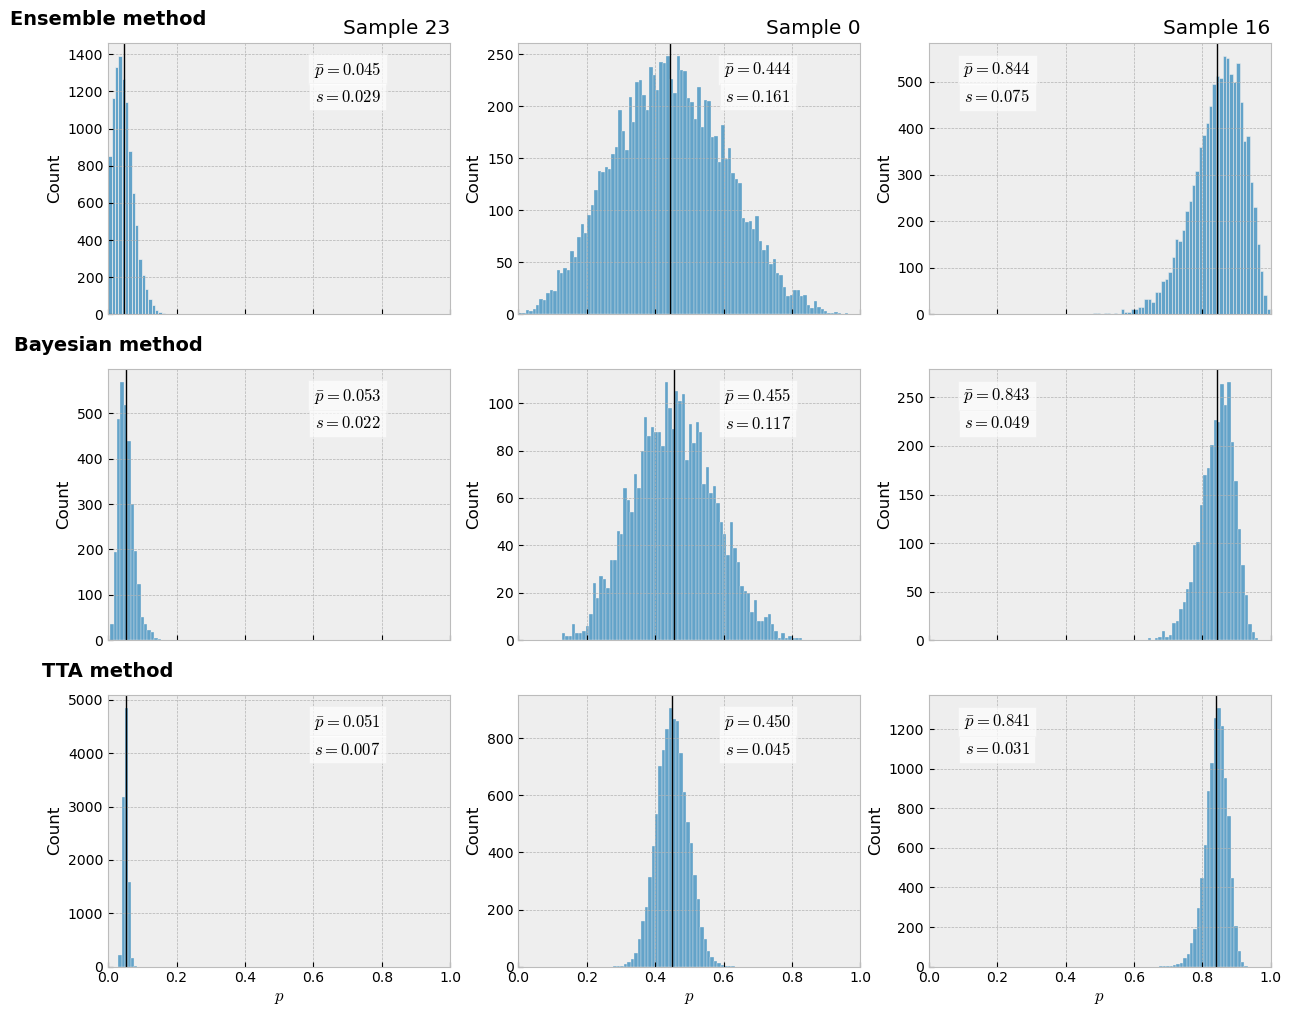

In [21]:
def plot_results(methods, results):
    """
    Graphical visualisation of the predicted probabilities for specific samples and methods.

    Args:
      methods (1d array-like): Names of the studied methods - One-dimensional array containing the names of the methods
      results (dictionary): Results of the different methods - Dictionary with the samples provided as keys and the predictions using the respective methods stored as values

    Returns:
      None
    
    """
    # Initialise figure based on the number of samples and methods to be analysed
    _, axes = plt.subplots(nrows=len(methods), ncols=len(results), figsize=(len(results)*5, len(methods)*4), sharex='col')
    
    # Provide headings of the analysed methods
    for i, m in enumerate(methods):
        axes[i, 0].annotate(m, xy=(0, 1.05), xycoords='axes fraction', ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Create a histogram for each sample and used method
    for s, key in enumerate(results.keys()):
        for m in range(len(methods)):
            if m == 0:
                axes[m,s].set_title('Sample ' + key, loc='right')
            
            elif m == len(methods)-1:
                axes[m,s].set_xlabel(r'$p$')

            # Plot the histogram
            data = results[key][m]
            sns.histplot(data, ax=axes[m,s], fill=True, binwidth=0.01)
            axes[m,s].set_xlim([0, 1]) 

            axes[m,s].axvline(np.mean(data), color='k', lw=1) # Add vertical line showing the mean value
            
            # Add mean and std in text boxes within the subplot
            if np.mean(data) < 0.5:
                pos_ann_x = 0.7
            else:
                pos_ann_x = 0.2
            axes[m,s].text(pos_ann_x, 0.9, r'$\bar p = {:.3f}$'.format(np.mean(data)), fontsize=12, color="black", ha="center", va="center", 
            transform=axes[m,s].transAxes, bbox=dict(facecolor='white', alpha=0.7))
            axes[m,s].text(pos_ann_x, 0.8, r'$s = {:.3f}$'.format(np.std(data, ddof=1)), fontsize=12, color="black", ha="center", va="center", 
            transform=axes[m,s].transAxes, bbox=dict(facecolor='white', alpha=0.7))                               
    plt.show()
    
methods = ["Ensemble method", "Bayesian method", "TTA method"]
plot_results(methods, uq_dict)

<b> Interpretation of the results </b> <br>
Firstly, we observe that the predicted probabilities for all three samples follow a (partially skewed) distribution for each method. <br>
To assess the uncertainty of the predicted probability, the standard deviation can be used as a measure of uncertainty. <br>
The standard deviation is the lowest when applying the TTA method. This is related to the fact that, using this method, aleatoric uncertainty is evaluated and that we defined the degree of augmentation ourselves. 
Hence, for datasets with large aleatoric uncertainty, the distributions can also have a wider range.
In contrast to TTA, the ensemble and Bayesian methods consider epistemic uncertainty. <br>
Furthermore, the figure shows that the ensemble method has a higher standard deviation compared to the Bayesian method for all three test samples. <br>
Of the three samples, the standard deviation is the highest for sample 0 (with a predicted probability of approx. 0.5). This is related to the fact that the sigmoid function has the highest slope at 0.5. <br>

The deterministic method computes the distance to the nearest ten samples as a measure of uncertainty. The results for our three samples are:

In [22]:
for i, p in enumerate(p_idx):
    print('Distance for Sample {:.0f}: {:.3f}'.format(p, distance[p_idx[i]]))

Distance for Sample 23: 2.575
Distance for Sample 0: 7.148
Distance for Sample 16: 2.864


It's of interest how these measures of uncertainty can now be used to support decision-making. The distance from the deterministic method provides a measure of how much a data point differs from our training cohort. This could be helpful for detecting out-of-distribution data (OOD), e.g. by defining a threshold that marks data as OOD. <br>
In contrast, the standard deviation cannot be directly compared quantitatively to indicate how reliable a prediction is. It is much more important how uncertainty influences the prediction. In our logistic regression example, the prediction is based on whether the probability is $p \geq 0.5$. Uncertainty can lead to this assignment being ambiguous. For our three test samples, only sample 0 is critical as here $p = 0.5$ lies within the 95%-confidence interval ( $\bar p \pm 1.96s$ ) for each method. The correct prediction is therefore not guaranteed when considering the underlying uncertainty. The task and function of the model, as well as the clinical objective, are therefore essential for evaluating the uncertainty measures.

<b> Analysis of the whole test cohort </b> <br>
We now consider the entire test cohort and assess the uncertainty metrics (standard deviation $s$ and distance $d$) for all samples:

In [23]:
def uncertainty_evaluation(X, param_ens, posterior, features, mean, std, X_train):
    """
    Application of uncertainty quantification methods on a dataset X.

    Args:
      X (pandas DataFrame): Test dataset - Two-dimensional array containing the features of the test dataset
      param_ens (pandas DataFrame): Parameters of the models forming the ensemble - Two-dimensional array whereas each row comprises the parameters for one model and the parameters are stored columnwise (beta0, beta1, beta2, beta3)
      posterior (posterior from the InferenceData object): Parameters of the models drawn from the posterior
      features (pandas DataFrame): Features of the test dataset (X) before preprocessing. This is required for the augmentation method - Two-dimensional array containing the features of the test dataset
      mean (pandas Series): Mean values of the features from the training dataset
      std (pandas Series): Standard deviation of the features from the training dataset
      X_train (pandas DataFrame): Training dataset - Two-dimensional array containing the features of the training dataset

    Returns:
      stds_ensemble (pandas Series): Calculated standard deviations for all samples in the test dataset after using the ensemble method
      stds_bayes (pandas Series): Calculated standard deviations for all samples in the test dataset after using the Bayesian method
      stds_aug (pandas Series): Calculated standard deviations for all samples in the test dataset after using the TTA method
      distance (pandas Series): Calculated sum of distances for all samples in the test dataset after using the deterministic method
    """
    
    # Ensemble method
    stds_ensemble = pd.Series(name='standard_deviation')

    for i in range(len(X)):
        std_ens_p = ensemble_inferred_uncertainty(param_ens, X.iloc[i, :]).std()
        stds_ensemble[len(stds_ensemble)] = std_ens_p

    # Bayesian method
    stds_bayes = pd.Series(name='standard_deviation')

    for i in range(len(X)):
        std_bay_p = bayesian_inferred_uncertainty(posterior, X.iloc[i, :]).std()
        stds_bayes[len(stds_bayes)] = std_bay_p

    # TTA method
    stds_aug = pd.Series(name='standard_deviation')

    for i in range(len(X)):
        features_augment = augment_data(features.iloc[i, :], 10000)
        features_augment.gross_tumour_volume = np.log(features_augment.gross_tumour_volume)
        features_augment = (features_augment - mean) / std    # use mean and std from all samples

        stds_aug[len(stds_aug)] = np.std(lr.predict_proba(features_augment)[:, 0], ddof=1)

    # Distance was already calculated for all patients in the previous step
    distance = pd.Series(distance_ood(X_train, X, 10), name='euclidean_distance')
    
    return stds_ensemble, stds_bayes, stds_aug, distance

stds_ensemble, stds_bayes, stds_aug, distance = uncertainty_evaluation(X_test, param_ens, idata.posterior, features_test, mean, std, X)

# Summarise the results in a dictionary for further processing - we add an identification for the used measure of uncertainty (std - standard deviation, dist - distance)
stds = {'Ensemble method': [stds_ensemble, 'std'], 
        'Bayesian method': [stds_bayes, 'std'], 
        'TTA method': [stds_aug, 'std'], 
        'Distance': [distance, 'dist']}

Now, we plot the results by assigning the uncertainty measures to the previously determined predicted probabilities for each data point:

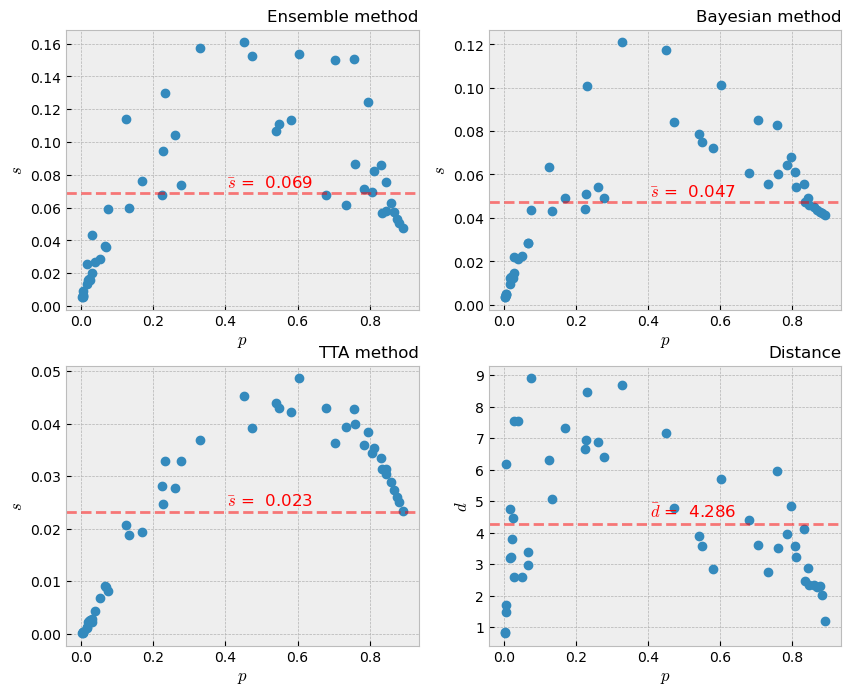

In [24]:
def plot_uncertainty(stds, probs, mw=True):
    """
    Visualisation of the results of different uncertainty quantification methods.
    
    Args:
      stds (dictionary): Standard deviations for all samples in the test dataset using different uncertainty quantification methods - the used methods are stored as keys, the calculated uncertainties and an identification of the used measure of uncertainty are stored as values
      probs (1d array-like):  Predicted probabilites of the logistic regression model - One-dimensional array contining the predicted probabilities
      mw (boolean): Visualisation of the median standard deviation (std) - if True - the median std will be printed and highlighted as a horizontal line

    Returns:
      axes (2d array-like): Array containing the axes element of the plot
    """
    
    n_rows = int(np.ceil(len(stds)/2))
    _, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows*4))  

    for i, m in enumerate(stds.keys()):
      ax = axes.flat[i]
      ax.plot(probs, stds[m][0], 'o')
      ax.set_xlabel(r'$p$', fontsize=12)

      if stds[m][1] == 'std':
        ax.set_ylabel(r'$s$', fontsize=12)
      elif stds[m][1] == 'dist':
        ax.set_ylabel(r'$d$', fontsize=12)
      else:
        ax.set_ylabel('mes. of uncert.', fontsize=12)
      
      ax.set_title(m, loc='right', fontsize=12)

      if mw == True:
        mean = stds[m][0].mean()
        ax.axhline(y=mean, color='r', linestyle='--', alpha=0.5)
        if stds[m][1] == 'std':
          ax.text(np.max(probs)/2.2, 1.05*mean, r'$\bar s$ =  {:.3f}'.format(mean), fontsize=12, color="r")
        elif stds[m][1] == 'dist':
          ax.text(np.max(probs)/2.2, 1.05*mean, r'$\bar d$ =  {:.3f}'.format(mean), fontsize=12, color="r")
        else:
          ax.text(np.max(probs)/2.2, 1.05*mean, r'$mean uncert.$ =  {:.3f}'.format(mean), fontsize=12, color="r")

        
    return axes
        
test = plot_uncertainty(stds, lr_test_proba)

plt.show()

The results shown in the figure confirm the general trends we observed for the specific samples from above:
- The mean standard deviation $\bar s$ is the highest for the ensemble method and the smallest for the TTA method.
- The standard deviation $s$ is higher for data points with a predictive probability of $ p \approx 0.5$.
- Furthermore, in this example, we do not see a correlation between the distance metric $d$ and the standard deviation $s$ of the other metrics. <br>

To further validate the latter, we calculate the  Spearman's rank correlation coefficient between the uncertainty metrics and show them using a heatmap:

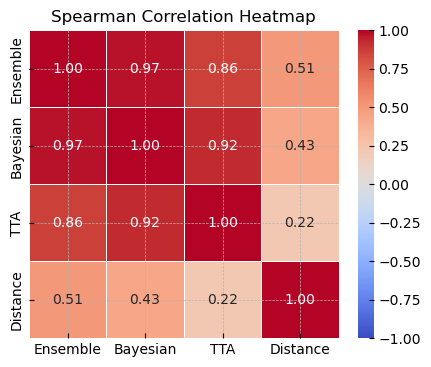

In [25]:
df_corr = pd.DataFrame({
    'Ensemble': stds_ensemble,
    'Bayesian': stds_bayes,
    'TTA': stds_aug,
    'Distance': distance})

spearman_corr = df_corr.corr(method='spearman')

plt.figure(figsize=(5,4))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Spearman Correlation Heatmap", fontsize=12)
plt.show()


The heatmap clearly shows that there are only smaller correlations between the distance and the calculated standard deviations.
However, this does not imply that the distance is not useful for uncertainty quantification. Rather, this shows that using different methods allows for different perspectives on uncertainty.
In practice, this means that different methods can for example be used and interpreted together to more comprehensively analyse the reason and amount of different types of uncertaintes. 

### 4.2. Shifted dataset
For the following analysis, we use a second dataset that was created with changed parameters. Here, we simulate the situation that our model should be applied to a new dataset, e.g. a second dataset, we got from another center. <br>
The uncertainty quantification can be done using the previously implemented methods.

First, we load the new, modified dataset from the corresponding .csv-file:

In [26]:
data_shift = pd.read_csv(r'synthetic_data/synthetic_data_shifted.csv', sep=';')
data_shift.head()

,dose_to_5_percent_of_lung_volume,gross_tumour_volume,n_chemotherapy_cycles,radiopneumonitis
0,67,10,4,0
1,31,20,6,0
2,27,26,6,0
3,46,10,6,1
4,57,27,6,0


<b>Preprocessing</b> <br>
We apply the same preprocessing steps as used for the inital dataset, including logarithmising the values of the gross tumor value and applying z-score normalisation using the same values as previously:

In [27]:
features_shift = data_shift.drop(columns = 'radiopneumonitis')
y_shift = data_shift.radiopneumonitis

features_log_shift = features_shift.copy()
features_log_shift.gross_tumour_volume = np.log(features_log_shift.gross_tumour_volume)

X_shift = (features_log_shift - mean) / std     # use mean and std from original distribution
X_shift.head()

,dose_to_5_percent_of_lung_volume,gross_tumour_volume,n_chemotherapy_cycles
0,1.387376,-1.604243,0.426123
1,-0.556786,-1.067227,1.154538
2,-0.772804,-0.863960,1.154538
3,0.253281,-1.604243,1.154538
4,0.847331,-0.834720,1.154538


To visualise the difference between the observed features in the original test dataset and the new shifted dataset, we apply a Principal Component Analysis (PCA) and visualise the pricipal components PC1 and PC2 in a scatter plot:

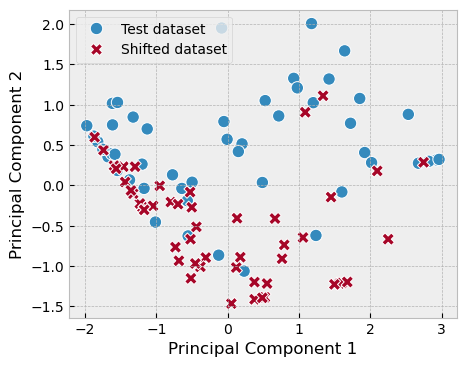

In [28]:
X_pca_test = X_test.copy()
X_pca_test["Label"] = "Test dataset"
X_pca_shift = X_shift.copy()
X_pca_shift["Label"] = "Shifted dataset"

# Combine both DataFrames
df_combined = pd.concat([X_pca_test, X_pca_shift])

# Apply PCA to reduce dimensions from 3D to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_combined.drop(columns=["Label"]))

# Create a new DataFrame with PCA results and added labels for the dataset
df_pca = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
df_pca["Label"] = df_combined["Label"].values

# Plot PCA results
plt.figure(figsize=(5, 4))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Label", style="Label", s=80)

# Labels and title
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend()
plt.show()

Although, there are overlapping datapoints, we see that overall the distribution of the datapoints slightly differs between the two datasets.

<b>Analysis of model performance</b> <br>
First, let's see how our model performs on this shifted dataset by calculating the accuracy and F1-score as well as by visualising the ROC and calculating the AUC:

Performance of the shifted dataset
Accuracy of the model: 66.00%
F1 Score of the model: 0.7302


(0.0, 1.0)

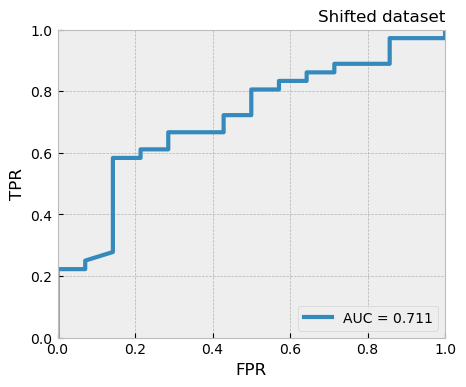

In [29]:
lr_shift = lr.predict(X_shift)
lr_shift_proba = lr.predict_proba(X_shift)[:,1]

print('Performance of the shifted dataset')
calc_metrics(lr_shift, y_shift)

# Plot ROC and calculate AUC
auc_shift = roc_auc_score(y_shift, lr_shift_proba)
fpr_shift, tpr_shift, _ = roc_curve(y_shift, lr_shift_proba)

fig = plt.figure(figsize=(5, 4))
plt.plot(fpr_shift, tpr_shift, linewidth=3, label='AUC = %0.3f' % auc_shift)
plt.title('Shifted dataset', loc='right', fontsize=12)
plt.legend(loc='lower right')
plt.xlabel('FPR', size=12)
plt.ylabel('TPR', size=12)
plt.xlim([0, 1])
plt.ylim([0, 1])
  

The ROC and the respective AUC show that the performance has dropped compared to the test dataset (see above). <br>

<b>Analysis / Quantification of uncertainties</b> <br>

For uncertainty quantification and visualisation, we use the previously implemented methods:

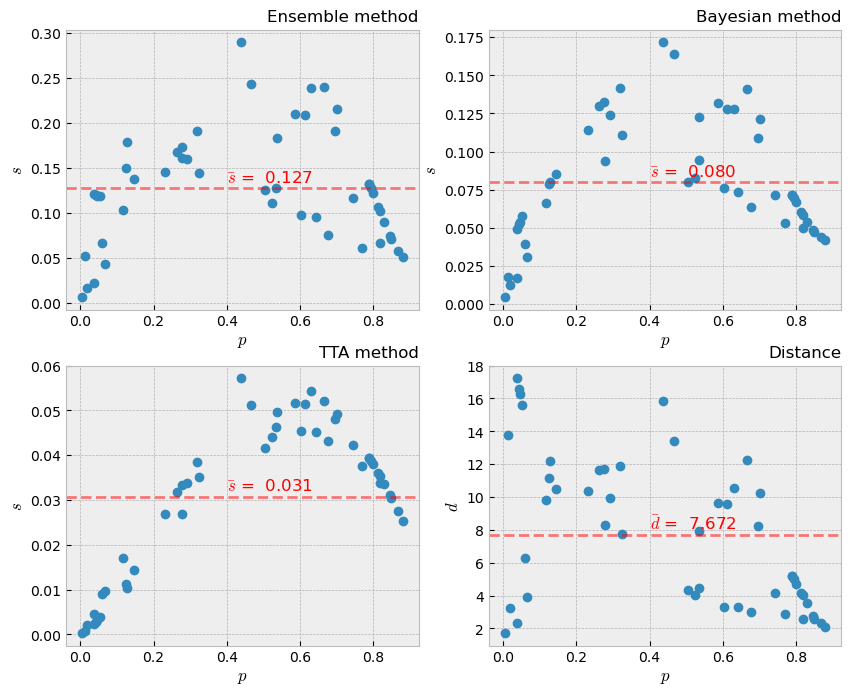

In [30]:
stds_shift_ens, stds_shift_bayes, stds_shift_aug, shift_distance = uncertainty_evaluation(X_shift, param_ens, idata.posterior, features_shift, mean, std, X)

stds_shift = {  'Ensemble method': [stds_shift_ens, 'std'], 
                'Bayesian method': [stds_shift_bayes, 'std'], 
                'TTA method': [stds_shift_aug, 'std'], 
                'Distance': [shift_distance, 'dist']}

plot_uncertainty(stds_shift, lr_shift_proba)
plt.show()

Firstly, we see that the uncertainty parameters (standard deviation $s$ and distance $d$) increased on average for the shifted dataset compared to the previous in-distribution dataset (see above). <br>
The mean standard deviation $\bar s$ almost doubled for the ensemble, Bayesian method as well as for the mean distance $\bar d$ of deterministic method. However, for the TTA method the increase is lower. This could imply that TTA methods are less sensitive to detect distributional shifts.

### 4.3. Out-of-distribution (OOD) data
In this example, we are looking at a dataset that has been manually manipulated to represent samples that can be considered to be out-of-domain, i.e. the features of the samples differ clearly form those observed in the training dataset. <br>

The dataset includes five artificial samples (patients) with the following characteristics: <br>

- <b>Sample 1 - OOD data class 0 </b>: The relationship between the features and outcome is realistic, but the feature values are outside the values in the training dataset (for class 0 - no radiopneumonitis) <br>
- <b>Sample 2 - OOD data class 1</b>: The relationship between the features and outcome is realistic, but the feature values are outside the values in the training dataset (for class 1 -  radiopneumonitis) <br>
- <b>Sample 3 - abnormal data class 0</b>: The relationship between the features and outcome is not realistic (for class 0 - no radiopneumonitis) <br>
- <b>Sample 4 - abnormal data class 1</b>: The relationship between the features and outcome is not realistic (for class 1 - radiopneumonitis) <br>
- <b>Sample 5 - normal sample</b>: The relationship between the features and outcome is realistic, just for comparison

As previously, we load the data from the respective .csv-file:

In [31]:
data_manip = pd.read_csv(r'synthetic_data/synthetic_data_manipulated.csv', sep=';')
data_manip.head()

,dose_to_5_percent_of_lung_volume,gross_tumour_volume,n_chemotherapy_cycles,radiopneumonitis
0,2,2,0,0
1,82,700,8,1
2,67,205,6,0
3,20,40,0,1
4,62,208,6,1


<b>Preprocessing</b> <br>
We apply the same preprocessing steps, as we logarithmise the gross tumour volume and apply z-score normalisation:

In [32]:
features_manip = data_manip.drop(columns='radiopneumonitis')
y_manip = data_manip.radiopneumonitis

features_log_manip = features_manip.copy()
features_log_manip.gross_tumour_volume = np.log(features_log_manip.gross_tumour_volume)

X_manip = (features_log_manip - mean) / std     # Use mean and std from the original distribution
X_manip.head()

,dose_to_5_percent_of_lung_volume,gross_tumour_volume,n_chemotherapy_cycles
0,-2.122917,-2.851157,-1.030708
1,2.197443,1.687284,1.882954
2,1.387376,0.735835,1.154538
3,-1.150836,-0.530210,-1.030708
4,1.117353,0.747090,1.154538


<b>Analysis / Quantification of uncertainties</b> <br>
We use the implemented methods to assess the standard deviation $s$ and distance $d$ as measures of uncertainty:

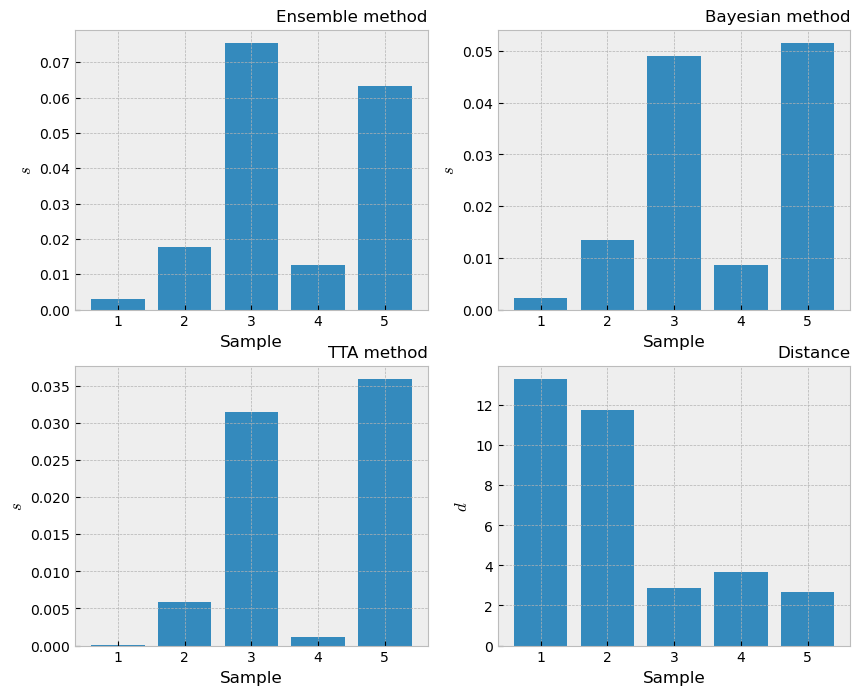

In [33]:
def plot_uncertainty_ood(stds):
    """
    Visualisation of the results of different uncertainty quantification methods.
    
    Args:
      stds (dictionary): Standard deviations for all samples in the test dataset using different uncertainty quantification methods - the used methods are given as keys, the calculated uncertainties and an identification of the used measure of uncertainty are stored as values
      
    Returns:
      None
    """
    
    n_rows = int(np.ceil(len(stds)/2))
    _, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows*4))  

    for i, m in enumerate(stds.keys()):
      ax = axes.flat[i]
      ax.bar(list(range(1, len(stds[m][0])+1)), stds[m][0])
      ax.set_xlabel('Sample', fontsize=12)

      if stds[m][1] == 'std':
        ax.set_ylabel(r'$s$', fontsize=12)
      elif stds[m][1] == 'dist':
        ax.set_ylabel(r'$d$', fontsize=12)
      else:
        ax.set_ylabel('mes. of uncertainty', fontsize=12)
      
      ax.set_title(m, loc='right', fontsize=12)        
    plt.show()

stds_manip_ens, stds_manip_bayes, stds_manip_aug, manip_distance= uncertainty_evaluation(X_manip, param_ens, idata.posterior, features_manip, mean, std, X)

stds_manip = {'Ensemble method': [stds_manip_ens, 'std'], 
              'Bayesian method': [stds_manip_bayes, 'std'], 
              'TTA method': [stds_manip_aug, 'std'], 
              'Distance': [manip_distance, 'dist']}

plot_uncertainty_ood(stds_manip)

Furthermore, we can visualise the predicted probability $p$ and determined standard deviation $s$ and distance $d$ in comparison to our test dataset:

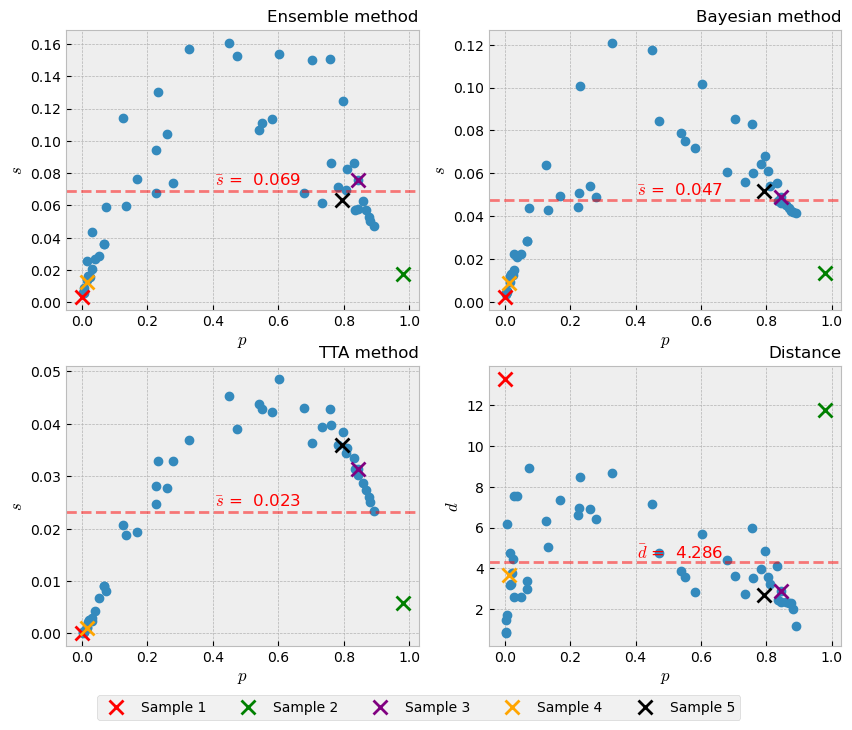

In [34]:
axes = plot_uncertainty(stds, lr_test_proba)
lr_shift_manip = lr.predict_proba(X_manip)[:, 1]

colours = ['red', 'green', 'purple', 'orange', 'black']
label = ['Sample 1', 'Sample 2', 'Sample 3','Sample 4','Sample 5']
for i, m in enumerate(stds_manip.keys()): 
    ax = axes.flat[i]
    for j in range(len(stds_manip[m][0])):
        ax.plot(lr_shift_manip[j], stds_manip[m][0][j], 'x', c=colours[j], label=label[j], markersize=10, mew=2)

plt.legend(loc='upper center', bbox_to_anchor=(-0.2, -0.15), ncol=5)  
plt.show()

<b>Ensemble, Bayesian, and TTA method</b> <br>
The figures show no abnormalities for the samples when compared with the results of the test dataset. This suggests that the methods are probably less suitable for detecting OOD data in our minimal example. <br>

<b>Deterministic method</b> <br>
Sample 1 and especially sample 2 have a distance of $d > 10$. Compared to the mean value $\bar d = 4.3$ for the internal test set. These results indicate a potential out-of-distribution case. 
The method is therefore well suited to recognise data whose feature values lie outside the training range. <br>
However, the method is less successful for the abnormal samples 3 and 4. The method is therefore not suitable for detecting samples with an unexpected endpoint.
Possibly, the method could be improved for this problem by also considering the class assignment of the data points into the algorithm.



## 5. Evaluation of uncertainty quantification
In the following, we show how the uncertainty metrics can be evaluated. For this we will have a look at <b>sparsification plots</b> and <b>conformal prediction</b>.<br>

### 5.1. Sparsification plots
Sparsification plots show how the performance of a model changes if a fraction of the most uncertain predictions is excluded from the tested dataset. The 10th- percentiles are usually removed step by step and the result is analysed repeatedly. <br>
In our example, we test how the AUC score changes if we remove the most uncertain predictions in the test and the shifted dataset. We use the Bayesian and the deterministic method to assess uncertainty.

In [35]:
def sparsification_plot(uncertainty, y, p):
    """
    Calculating the area under the curve (AUC) score after removing the x-th percentile (0, 10, 20, ..., 90) of the most uncertain data of the dataset that is tested.

    Args:
        uncertainty (pandas Series): Uncertainty measure for each data point in the test set - Series with the highest value corresponding to the highest uncertainty
        y (pandas Series): Outcome for each data point in the test set - Series that contains the outcome for each sample (0 or 1)
        p (pandas Series): Class-probability for each data point in the test set - Series that contains the probability for each sample

    Returns:
        auc_scores (list): List of the calculated AUC for each percentile (0 - 90) 
    """

    percentiles = np.arange(0, 1, 0.1)
    auc_scores = []
    for percentile in percentiles:
        uncertainty_crit = uncertainty.quantile(1 - percentile)
        y_perc = y[uncertainty.values < uncertainty_crit]
        p_perc = p[uncertainty.values < uncertainty_crit]
        
        # If the remaining test set consists only of data from one outcome, the auc_score is set to 1
        if y_perc.sum() == 0 or y_perc.sum() == len(y_perc):
            auc_scores.append(1)
        else:
            auc_scores.append(roc_auc_score(y_perc, p_perc))

    return auc_scores

To compare the results for the two methods and datasets, we visualise the Sparsification plots:

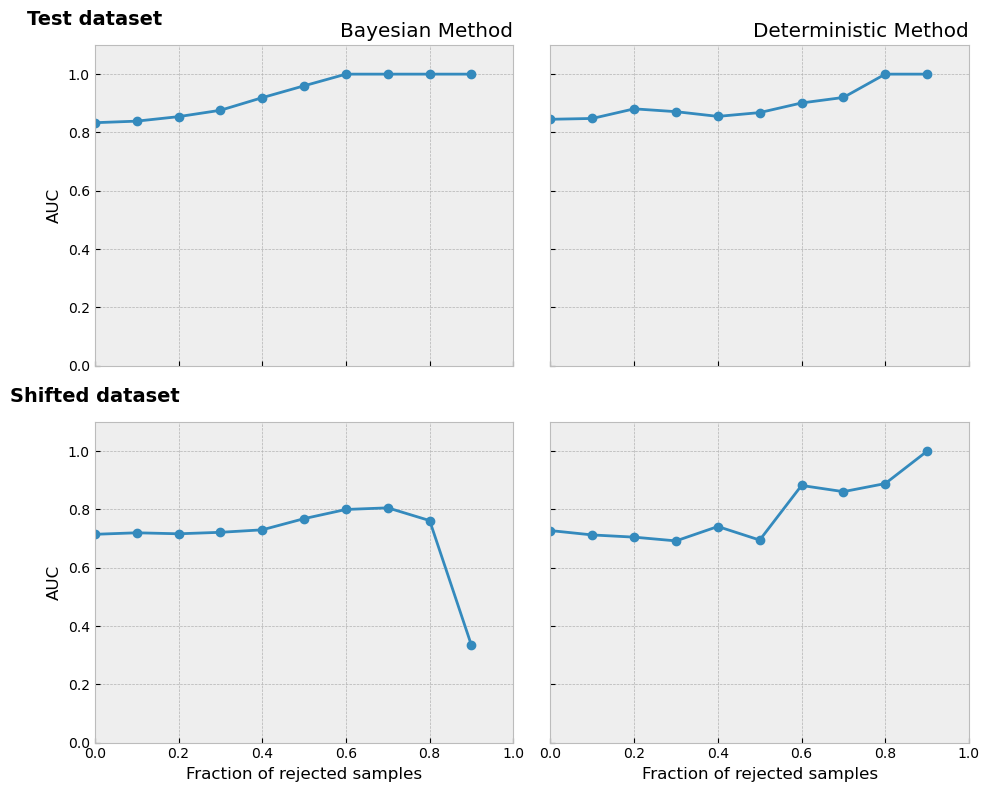

In [36]:
auc_test_bayes = sparsification_plot(stds_bayes, y_test, lr_test_proba)
auc_shift_bayes = sparsification_plot(stds_shift_bayes, y_shift, lr_shift_proba)

auc_test_dist = sparsification_plot(distance, y_test, lr_test_proba)
auc_shift_dist = sparsification_plot(shift_distance, y_shift, lr_shift_proba)

percentiles = np.arange(0, 1, 0.1)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)

axes[0, 0].annotate('Test dataset', xy=(0, 1.05), xycoords='axes fraction', ha='center', va='bottom', fontsize=14, fontweight='bold')
axes[1, 0].annotate('Shifted dataset', xy=(0, 1.05), xycoords='axes fraction', ha='center', va='bottom', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim(0,1)
axes[0, 0].set_ylim(0,1.1)

axes[0,0].plot(percentiles,auc_test_bayes,'-o')
axes[0,0].set_ylabel('AUC', fontsize=12)
axes[0,0].set_title('Bayesian Method', loc='right')

axes[0,1].plot(percentiles,auc_test_dist,'-o')
axes[0,1].set_title('Deterministic Method', loc='right')

axes[1,0].plot(percentiles,auc_shift_bayes,'-o')
axes[1,0].set_ylabel('AUC', fontsize=12)
axes[1,0].set_xlabel('Fraction of rejected samples', fontsize=12)

axes[1,1].plot(percentiles,auc_shift_dist,'-o')
axes[1,1].set_xlabel('Fraction of rejected samples', fontsize=12)

plt.tight_layout()
plt.show()


<b>Interpretation</b> <br>

<b>Test dataset</b> <br>
The AUC increases the more samples are rejected for both methods. The deterministic method only leads to a substantial improvement in performance starting at a fraction of $0.7$. The Bayesian method leads to continuous improvement with increasing rejection.  <br>

<b>Shifted dataset</b> <br>
The Bayesian method does not lead to any real improvement in performance in this dataset (with exception of fraction $0.6$). The deterministic method initially worsens the performance, but from a fraction of $0.5$ the performance improves considerably. <br>

Based on these plots, threshold values could be determined in a clinical scenario above which the uncertainty is too high to trust the model decision.



### 5.2. Conformal prediction
Conformal prediction has gained popularity as an intuitive framework for uncertainty quantification. <br>

Conformal prediction can be implemented in a transductive (based on the training data) or inductive (based on a calibration set) way. In our example, we choose an inductive approach. For this, we first load a calibration dataset. This dataset was created in the same way as our initial dataset and includes $N = 500$ samples. <br>

In [12]:
data_calib = pd.read_csv(r'synthetic_data/synthetic_data_calibration.csv', sep=';')
data_calib.head()

,dose_to_5_percent_of_lung_volume,gross_tumour_volume,n_chemotherapy_cycles,radiopneumonitis
0,22,88,0,0
1,14,13,0,0
2,25,23,0,0
3,40,12,0,0
4,29,19,5,0


We first apply preprocessing and use the same methods as previously:

In [13]:
features_calib = data_calib.drop(columns='radiopneumonitis')
y_calib = data_calib.radiopneumonitis

features_calib_log = features_calib.copy()
features_calib_log.gross_tumour_volume = np.log(features_calib_log.gross_tumour_volume) 

X_calib = (features_calib_log - mean) / std     # Use mean and std from the original distribution

The central component of our uncertainty evaluation is a so called non-conformity measure $\alpha$ which represents the abnormality of a new data point compared to the existing data (in our case the calibration data). The non-conformity measure can be, e.g.: <br>
- the probability for predicting the wrong class
- a measure of spread like the standard deviation that reflects how uncertain the predicted outcome is (ensemble, Bayesian, TTA method)
- a distance measure that reflects how distant/different the data is from the training dataset (deterministic method)

In our example, we demonstrate conformal prediction for predicting the wrong class as a non-conformity measure. <br>

<b>Probability for predicting the wrong class </b> <br>
 For this non-conformity measure $\alpha$, we can directly calculate the predicted probability output of our model:

In [14]:
prob_calib = lr.predict_proba(X_calib)

The probability of predicting the wrong class equals $1-p$. In the case of our array, we can directly calculate the non-conformity measure $\alpha$ based on the following equation: <br> 

$$
\alpha_{i}= |y_{i}-p_{i,y=1}|
$$

In [15]:
alpha_calib = np.abs(y_calib - prob_calib[:, 1])

We can now calculate a p-value $p_{m+1}$ for a new data point $X_{m+1}$. <br> 
To do this, we look at our calibration dataset to see how many data points have a higher non-conformity score $\alpha_{1...m}$ than our new point $\alpha_{m+1}$ and set this in relation to the total number of points in the calibration set :
$$
p_{m+1}=\frac{|i=1,...,m:\alpha_{i} \geq \alpha_{m+1}|+1}{m+1}
$$

Note: The $+1$ in numerator and denominator are needed to account for the new data point in the set.

In [16]:
def calculate_p_cp(alpha_new_data, alpha_calibration):
    """
    Calculation of the p-value for a new datapoint compared to datapoints in a calibration dataset.

    Args:
        alpha_new_data (float): Non-conformity measure of a new data point
        alpha_calibration (pandas Series): Non-conformity measure for the calibration dataset - Series that contains the non-conformity measure for each sample in the calibration dataset

    Returns:
        p_cp (float): p-value for the new datapoint
    """
    p_cp = (np.sum(alpha_calibration >= alpha_new_data) + 1) / (len(alpha_calibration) + 1)
    
    return p_cp

In the following, we will perform the conformal prediction for the previously used patients from the test dataset (<b>Sample 23, 0 and 16</b>). <br>
For a new data point we normally do not know a priori whether it is in class 0 or 1. For this reason, we have to determine a non-conformity score for both cases.

In [17]:
index_list = [23, 0, 16]

alpha_test = {}
for i, sample in enumerate(index_list):
    prob_test = lr.predict_proba(X_test.iloc[sample:sample+1, :])[0]
    alpha_test[sample] = [prob_test[1], prob_test[0]]


for p in alpha_test.keys():
    print('Non-conformity scores for Sample {:.0f} - alpha(y=0): {:.4f}; alpha(y=1): {:.4f}'.format(p, alpha_test[p][0], alpha_test[p][1]))

Non-conformity scores for Sample 23 - alpha(y=0): 0.0510; alpha(y=1): 0.9490
Non-conformity scores for Sample 0 - alpha(y=0): 0.4500; alpha(y=1): 0.5500
Non-conformity scores for Sample 16 - alpha(y=0): 0.8439; alpha(y=1): 0.1561


The p-value for each class can now be determined for these patients. The prediction set is then formed on the basis of the p-values. <br>
The prediction set is a summary of all predictions that are realistic. For our binary classification problem, this can take the states {0}, {1}, or {0,1}. Whether a prediction is included in the set is determined on the basis of a self-chosen significance level $\varepsilon$. All $p \geq \varepsilon $ are included. In our example, we choose $\varepsilon=0.1$.

In [22]:
epsilon = 0.1

p_val = {}
prediction_set = {}
for sample in index_list:
    p_val[sample] = [calculate_p_cp(alpha_test[sample][0], alpha_calib), calculate_p_cp(alpha_test[sample][1], alpha_calib)]
    new_prediction_set = []

    if p_val[sample][0] >= epsilon:
        new_prediction_set.append(0)        
    if p_val[sample][1] >= epsilon:
        new_prediction_set.append(1)

    prediction_set[sample] = new_prediction_set


    print('Sample ', sample,': \n',
          'p-value for outcome 0 (no radiopneumonitis): {:.3f} \n'.format(p_val[sample][0]),
          'p-value for outcome 1 (radiopneumonitis):    {:.3f} \n'.format(p_val[sample][1]),
          'Resulting prediction set for sample', sample,':     ',f"{{{', '.join(map(str, prediction_set[sample]))}}}", '\n'
          )

Sample  23 : 
 p-value for outcome 0 (no radiopneumonitis): 0.671 
 p-value for outcome 1 (radiopneumonitis):    0.010 
 Resulting prediction set for sample 23 :      {0} 

Sample  0 : 
 p-value for outcome 0 (no radiopneumonitis): 0.248 
 p-value for outcome 1 (radiopneumonitis):    0.206 
 Resulting prediction set for sample 0 :      {0, 1} 

Sample  16 : 
 p-value for outcome 0 (no radiopneumonitis): 0.054 
 p-value for outcome 1 (radiopneumonitis):    0.493 
 Resulting prediction set for sample 16 :      {1} 



We see that the patients with a high probability for the respective class (sample 23 and 16) only contain the one correct class in the prediction set. In contrast, for patient 0 both classes are included in the prediction set. This is exactly what the intention of these prediction sets is. Predictions with a higher uncertainty will lead to larger prediction sets. This is a very easy to interpret representation of uncertainty. In addition, conformal prediction also provides the p-value, which is a quantitative parameter that can be easily compared for different samples. <br>
Another advantage is the flexibility of appliying conformal prediction. Our example shows only one way of implementing conformal prediction, but it can be applied to almost all types of models, is not restricted to a specific distribution of the data, and can be individually adapted to particular problems with a specific non-conformity measure.

## 6. Summary

This notebook shows how uncertainty quantification can be applied for outcome prediction in radiation oncology. 
Here, we used a minimal example to predict a binary outcome using logistic regression.
However, the presented methods can also be applied to more complex approaches, e.g. neural networks.
The main idea presented is to estimate and quantifiy a variable to assess the uncertainty. Here, we used the standard deviation of generated distributions (for the ensemble, Bayesian and TTA method) as well as a distance (for a deterministic method). 
Depending on the modelling approach, the calculation of those parameters can be quite straightforward and might also be easily implemented. <br>

In this notebook, we assessed parameters for the quantification of uncertainty using the test dataset, a shifted dataset as well as a datatset containing samples that are supposed to be out-of-domain.
The visualisation of the results shows that all of the analysed methods (ensemble, Bayesian, TTA and deterministic method) can have advantages and disadvantages. <br>

Although, the presented methods can be applied to different problems, it is important to note, that the interpretation of the measures of uncertainty and the associated implications are assessed and discussed in a problem-specific manner. Finally, there is no one-fits-all approach for analysing and interpreting uncertainites in clinical practice.